play with .bam file with pysam 

In [2]:
import pysam
path2bam = "/mnt/archgen/users/yilei/Data/BAM/I10939/I10939_1240k.bam"

In [3]:
sf = pysam.AlignmentFile(path2bam, "rb")

In [27]:
print(sf.references)
print(sf.lengths)

('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT', 'GL000207.1', 'GL000226.1', 'GL000229.1', 'GL000231.1', 'GL000210.1', 'GL000239.1', 'GL000235.1', 'GL000201.1', 'GL000247.1', 'GL000245.1', 'GL000197.1', 'GL000203.1', 'GL000246.1', 'GL000249.1', 'GL000196.1', 'GL000248.1', 'GL000244.1', 'GL000238.1', 'GL000202.1', 'GL000234.1', 'GL000232.1', 'GL000206.1', 'GL000240.1', 'GL000236.1', 'GL000241.1', 'GL000243.1', 'GL000242.1', 'GL000230.1', 'GL000237.1', 'GL000233.1', 'GL000204.1', 'GL000198.1', 'GL000208.1', 'GL000191.1', 'GL000227.1', 'GL000228.1', 'GL000214.1', 'GL000221.1', 'GL000209.1', 'GL000218.1', 'GL000220.1', 'GL000213.1', 'GL000211.1', 'GL000199.1', 'GL000217.1', 'GL000216.1', 'GL000215.1', 'GL000205.1', 'GL000219.1', 'GL000224.1', 'GL000223.1', 'GL000195.1', 'GL000212.1', 'GL000222.1', 'GL000200.1', 'GL000193.1', 'GL000194.1', 'GL000225.1', 'GL000192.1')
(249250621, 243199373, 198022430, 

690638 reads aligned to region 10000000.0-50000000.0
421053 reads have mapping quality greater than 20.


(array([230553.,   6058.,   8346.,   6845.,  12115.,   5668.,  21559.,
             0.,      0., 399494.]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <a list of 10 Patch objects>)

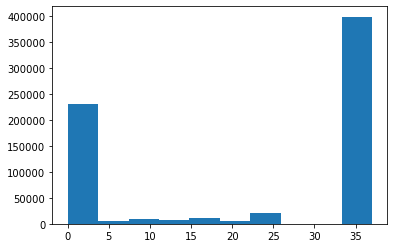

In [31]:
start = 1e7
end = 5e7
MapQual = []
count_highQ = 0
for read in sf.fetch('X'):
    mapq = read.mapping_quality
    MapQual.append(read.mapping_quality)
    if mapq > 20:
        count_highQ += 1
ct = sf.count('X')
print(f'{ct} reads aligned to region {start}-{end}')
print(f'{count_highQ} reads have mapping quality greater than 20.')

import matplotlib.pyplot as plt
plt.hist(MapQual)


In [5]:
for pileupcolumn in sf.pileup("X", 10000000, 10000001):
    print ("\ncoverage at base %s = %s" %
           (pileupcolumn.pos, pileupcolumn.n))
    for pileupread in pileupcolumn.pileups:
        if not pileupread.is_del and not pileupread.is_refskip:
            # query position is None if is_del or is_refskip is set.c
            print ('\tbase in read %s = %s' %
                  (pileupread.alignment.query_name,
                   pileupread.alignment.query_sequence[pileupread.query_position]))

In [5]:
import h5py
import numpy as np
import gzip
import time
# compare mismatch rate at variable and non-variable sites
# grep all variable sites on chrX from 1240k panel
# f = h5py.File('/mnt/archgen/users/yilei/Data/1000G/1000g1240khdf5/all1240/chrX.hdf5', 'r')
# pos = f['variants/POS']

#use ANGSD's HapMapChrX instead?
pos = []
with gzip.open('/mnt/archgen/users/yilei/bin/angsd/RES/HapMapChrX.gz') as file:
    for line in file:
        phy, *_ = line.strip().split()
        pos.append(int(phy))
print(f'number of SNP sites to check: {len(pos)}')
pos = np.array(pos)
pos -= 1 # pysam's use 0-based coordinate system
pos = pos[:10]

major_adj = 0
minor_adj = 0
major_foc = 0
minor_foc = 0

base2index = {'A':0, 'C':1, 'G':2, 'T':3}
t = 0.0

for p in pos:
    #print(f'###### focal site: {p} #######')
    for pileupcolumn in sf.pileup('X', p-4, p+5, min_mapping_quality=30, min_base_quality=20):
        basePos = pileupcolumn.pos
        cov = pileupcolumn.n
        if cov == 1:
            continue
        if basePos >= p+5:
            break
        elif basePos < p-4: #or basePos == p:
            continue
        else:
            rc = np.zeros(4)
            print(f'coverage at base {pileupcolumn.pos}: {pileupcolumn.n}')
            for pileupread in pileupcolumn.pileups:
                if not pileupread.is_del and not pileupread.is_refskip:
                    baseCall = pileupread.alignment.query_sequence[pileupread.query_position]
                    rc[base2index[baseCall]] += 1
            if basePos != p:
                major_adj += np.max(rc)
                minor_adj += np.sum(rc) - np.max(rc)
            else:
                major_foc += np.max(rc)
                minor_foc += np.sum(rc) - np.max(rc)
            if np.sum(rc == 0) < 2:
                print(f'more than 2 genotype calls at {basePos}')

print(f'number of major reads at flanking sites: {major_adj}')
print(f'number of minor reads at flanking sites: {minor_adj}')
print(f'number of major reads at focal sites: {major_foc}')
print(f'number of minor reads at focal sites: {minor_foc}')

print(f'err rate at flanking sites: {minor_adj/(minor_adj + major_adj)}')
print(f'err rate at focal sites: {minor_foc/(minor_foc + major_foc)}')




number of SNP sites to check: 73562
